Everyone is busy downloading and there was no kernel that kind of does the initial exploration to see how the images look like and how would a simple work on this dataset. Hence I went forward and created one. This kernel does not save any file locally and just uses them on the fly during training using a keras generator. Time ranges around ~240secs for an epoch with total 1280 images on a ResNet50 (with very minimal number of classes). There may be a few mistakes, you never know.

Happy Kaggling!

In [1]:
import requests
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import threading
import urllib
import cv2
import time

import keras
from keras.applications import ResNet50
from keras import backend as K
from keras import regularizers
from keras.engine.topology import Input
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, GlobalMaxPooling2D, \
    Lambda, MaxPooling2D, Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.utils import Sequence
from sklearn.model_selection import train_test_split

from collections import Counter

import os
import tarfile

Using TensorFlow backend.


# DATA
## Let's download the train set first.
## and set some usefull values

In [2]:
## Usefull values
DATAPATH = 'data/'

URLTRAINFILE = "https://s3.amazonaws.com/google-landmark/metadata/train.csv"
TRAINFILE = 'train.csv'

URLATTRIBFILE = "https://s3.amazonaws.com/google-landmark/metadata/train_attribution.csv"
ATTRIBFILE = "train_attribution.csv"


# It's time to load and beguin to work with data
## First loading DataFrames

In [3]:
train = pd.read_csv(DATAPATH + TRAINFILE)
print(train.head())
print(train.shape)
print("Number of classes {}".format(len(train.landmark_id.unique())))

                 id                                                url  \
0  6e158a47eb2ca3f6  https://upload.wikimedia.org/wikipedia/commons...   
1  202cd79556f30760  http://upload.wikimedia.org/wikipedia/commons/...   
2  3ad87684c99c06e1  http://upload.wikimedia.org/wikipedia/commons/...   
3  e7f70e9c61e66af3  https://upload.wikimedia.org/wikipedia/commons...   
4  4072182eddd0100e  https://upload.wikimedia.org/wikipedia/commons...   

   landmark_id  
0       142820  
1       104169  
2        37914  
3       102140  
4         2474  
(4132914, 3)
Number of classes 203094


In [6]:
attrib = pd.read_csv(DATAPATH + ATTRIBFILE)
print(attrib.head())
print(attrib.shape)
print("Number of authors {}".format(len(attrib.author.unique())))

                 id                                                url  \
0  6e158a47eb2ca3f6  http://commons.wikimedia.org/wiki/File:Observa...   
1  202cd79556f30760  http://commons.wikimedia.org/wiki/File:Ecosse2...   
2  3ad87684c99c06e1  http://commons.wikimedia.org/wiki/File:Pirmase...   
3  e7f70e9c61e66af3  http://commons.wikimedia.org/wiki/File:Occiden...   
4  4072182eddd0100e  http://commons.wikimedia.org/wiki/File:Looking...   

                                      author  \
0                            Holger.Ellgaard   
1                                 LeCardinal   
2                                   LoKiLeCh   
3                              Andrés Osorio   
4  Stephen Whittaker and Katharine Oakeshott   

                                             license  \
0  CC BY-SA 3.0(http://creativecommons.org/licens...   
1  CC-BY-SA-3.0(http://creativecommons.org/licens...   
2  GFDL(http://www.gnu.org/copyleft/fdl.html)/CC-...   
3  CC BY 2.0(http://creativecommons.org/li

### So there are a whopping ~200k landmarks in this dataset. Now I don't want to use all these 200k categories. Majority of them will have very examples of it. So I'll exclude categories that have less than a certain threshold number of images to it's name and also those ones that I did not download yet

In [22]:
img_id = train.loc[1,'id']
img_dir = 'data/{}/{}/{}/{}.jpg'.format(train.loc[1,'id'][0],train.loc[1,'id'][1],train.loc[1,'id'][2],train.loc[1,'id']) 


print(train.loc[1,'url'])

print(train.loc[1,'id'][0])

print(img_dir)

# train['img_dir']=train.apply(lambda row: 'data/{}/{}/{}/{}.jpg'.format(row.id[0],row.id[1],row.id[2],row.id), axis=1)

print(train.loc[1,'img_dir'])

print(train.head())
print(train.shape)

http://upload.wikimedia.org/wikipedia/commons/6/63/Ecosse200996-1.jpg
2
data/2/0/2/202cd79556f30760.jpg
data/2/0/2/202cd79556f30760.jpg
                 id                                                url  \
0  6e158a47eb2ca3f6  https://upload.wikimedia.org/wikipedia/commons...   
1  202cd79556f30760  http://upload.wikimedia.org/wikipedia/commons/...   
2  3ad87684c99c06e1  http://upload.wikimedia.org/wikipedia/commons/...   
3  e7f70e9c61e66af3  https://upload.wikimedia.org/wikipedia/commons...   
4  4072182eddd0100e  https://upload.wikimedia.org/wikipedia/commons...   

   landmark_id                          img_dir  
0       142820  data/6/e/1/6e158a47eb2ca3f6.jpg  
1       104169  data/2/0/2/202cd79556f30760.jpg  
2        37914  data/3/a/d/3ad87684c99c06e1.jpg  
3       102140  data/e/7/f/e7f70e9c61e66af3.jpg  
4         2474  data/4/0/7/4072182eddd0100e.jpg  
(4132914, 4)


In [23]:
NUM_THRESHOLD = 250

counts = dict(Counter(train['landmark_id']))
landmarks_dict = {x:[] for x in train.landmark_id.unique() if counts[x] >= NUM_THRESHOLD}
NUM_CLASSES = len(landmarks_dict)
print("Total number of valid classes: {}".format(NUM_CLASSES))

Total number of valid classes: 1067


In [26]:
i = 0
landmark_to_idx = {}
idx_to_landmark = []
for k in landmarks_dict:
    landmark_to_idx[k] = i
    idx_to_landmark.append(k)
    i += 1

all_paths = train['img_dir'].tolist()
all_landmarks = train['landmark_id'].tolist()
valid_path_dict = {x[0]:landmark_to_idx[x[1]] for x in zip(all_paths, all_landmarks) if x[1] in landmarks_dict and os.path.isfile(x[0])}
valid_path_list = [x[0] for x in zip(all_paths, all_landmarks) if x[1] in landmarks_dict and os.path.isfile(x[0])]

NUM_EXAMPLES = len(valid_path_list)
print("Total number of valid examples: {}".format(NUM_EXAMPLES))

Total number of valid examples: 280106


In [83]:
print(valid_path_list[0:5])

print(idx_to_landmark[0:5])

len(valid_path_dict)

['data/4/0/7/4072182eddd0100e.jpg', 'data/0/5/3/053d1409647dfba2.jpg', 'data/3/c/d/3cdc355c6232712f.jpg', 'data/6/1/0/610d92e487e79c4d.jpg', 'data/1/a/7/1a70f92ba679fac0.jpg']
[2474, 138982, 74821, 12877, 156009]


280106

## Let us check a few sample images from the dataset. First we'll check a few images overall. In the next plot, we'll see how similar are the images from the same categories

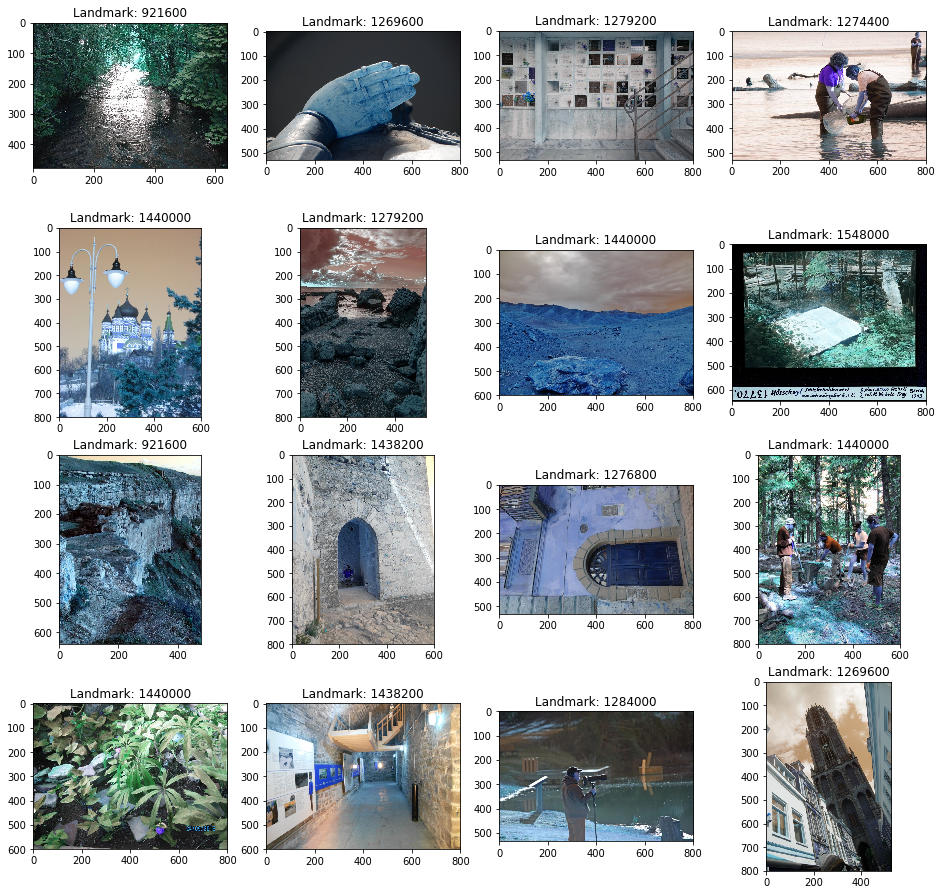

In [54]:
w=20
h=20
fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 4
i = 1
for path in valid_path_list[:16]:
    im = cv2.imread(path)
    if im.size != 0:
        fig.add_subplot(rows, columns, i)
        plt.title("Landmark: " + str(im.size)) # + str(idx_to_landmark[valid_path_list[i]]))
        plt.imshow(im)
        i += 1

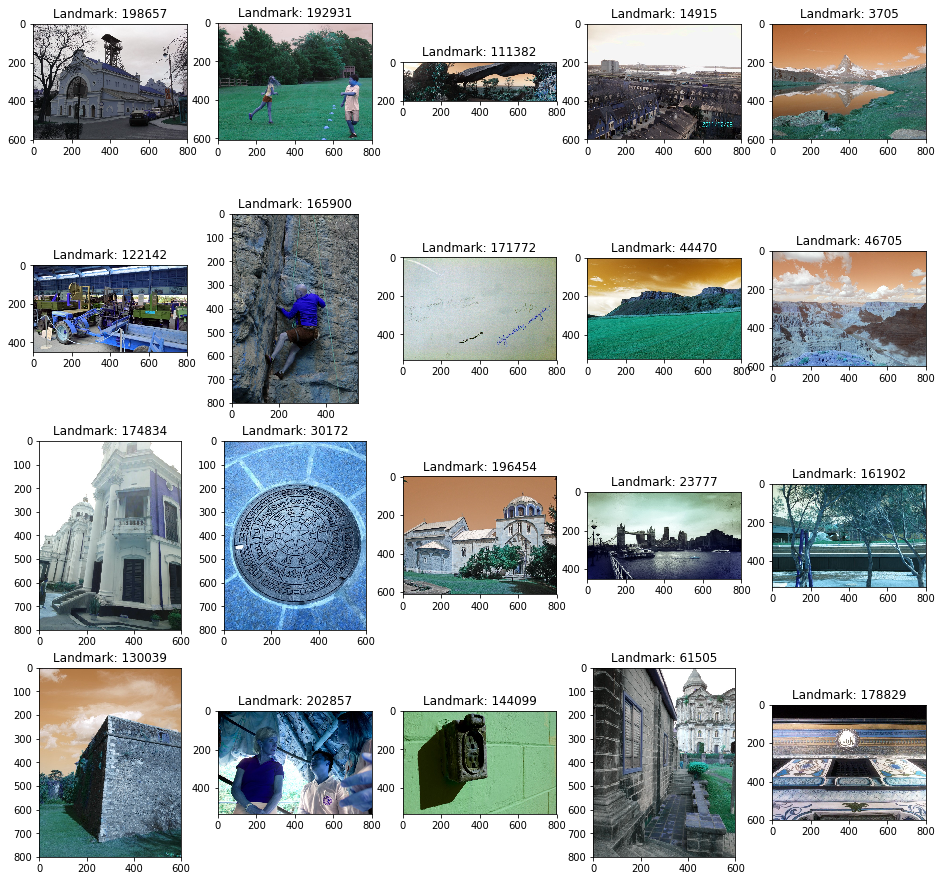

In [82]:
w=20
h=20
fig=plt.figure(figsize=(16, 16))
columns = 5
rows = 4

path = random.sample(valid_path_dict.keys(),20)
landmarks = [idx_to_landmark[valid_path_dict[x]] for x in path ]

for i in range(20):
    img = cv2.imread(path[i],1)
    if img.size != 0:
        fig.add_subplot(rows, columns, i+1)
        plt.title("Landmark: " + str(landmarks[i]))
        plt.imshow(img)

So, it is quite a noisy dataset. It is difficult to understand correctly how one image is connected to other in some categories.

Not worrying about the noise in the data, let's proceed. Now we will create a train and validation set from the valid examples.

# Creating the net
## using Tensorflow

In [ ]:
import tensorflow as tf

tf.enable_eager_execution()


In [90]:
train_set, validation_set = train_test_split(valid_path_list, test_size=int(1*NUM_EXAMPLES/4))
print( 'We shall use {} elements for training and {} elements to test'.format(len(train_set), len(validation_set)))

We shall use 210080 elements for training and 70026 elements to test


In [ ]:
validation_images = []
validation_y = []
for path in validation_paths:
    im = download_image_cv2_urllib(url)
    if im.size != 0:
        validation_images.append(im)
        validation_y.append(valid_urls_dict[url.split("/")[-1]])

valid_x = np.array(validation_images)
valid_y = np.zeros((len(validation_images), NUM_CLASSES))
        
for i in range(len(validation_y)):
    valid_y[i,validation_y[i]] = 1.

In [ ]:

class DataGen(Sequence):
    def __init__(self, data, batch_size=24, verbose=1):
        self.batch_size=batch_size
        self.data_urls = data

    def normalize(self,data):
        return data
    
    def __getitem__(self, index):
        batch_urls = random.sample(self.data_urls, self.batch_size)
        
        output = []
        y_classes = []
        for url in batch_urls:
            im = download_image_cv2_urllib(url)
            if im.size != 0:
                output.append(im)
                y_classes.append(valid_urls_dict[url.split("/")[-1]])
        
        x = np.array(output)
        y = np.zeros((len(output), NUM_CLASSES))
        
        for i in range(len(y_classes)):
            y[i,y_classes[i]] = 1.
        
        return x,y
            
    def on_epoch_end(self):
        return

    def __len__(self):
        #return len(valid_urls_list) // self.batch_size
        return 10

In [ ]:
def accuracy_class(y_true, y_pred):
    true = K.argmax(y_true, axis=1)
    pred = K.argmax(y_pred, axis=1)
    matches = K.equal(true, pred)
    return K.mean(matches)

In [ ]:
res = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

In [ ]:
for layer in res.layers[:120]:
    layer.trainable = False

In [ ]:
out = Flatten()(res.output)
out = Dense(NUM_CLASSES, activation='softmax')(out)
model = Model(res.input, out)
model.summary()

In [ ]:
opt = Adam(0.0001)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=[accuracy_class])
model.fit_generator(generator=DataGen(train_urls, batch_size=128),
                    validation_data=[valid_x, valid_y],
                    epochs=80,
                    use_multiprocessing=True,
                    workers=8,
                    verbose=1)